# 加载数据

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [1]:
train_test = "test"

In [3]:
# 读取 JSON 文件
import json
with open(f'/home/yltang/data/simulated_data_1/data_new/data_v2/{train_test}_data.json', 'r') as file:
    data_list = json.load(file)

with open(f"/home/yltang/data/simulated_data_1/data_new/data_v2/{train_test}_label.json","r") as file:
   label_list = json.load(file)

with open(f"/home/yltang/data/simulated_data_1/data_new/data_v2/{train_test}_redshift.json","r") as file:
    redshift_list = json.load(file)

In [4]:
len(data_list), len(redshift_list)

(19686, 19686)

In [5]:
redshift_list[:10]

[0.55129,
 0.31985,
 0.29005,
 0.64448,
 0.28777,
 0.54451,
 0.34563,
 0.22158,
 0.5804,
 0.48455]

In [6]:
index_list = list(range(len(data_list)))

In [7]:
sample = 0

In [8]:
sample += 1

0.0

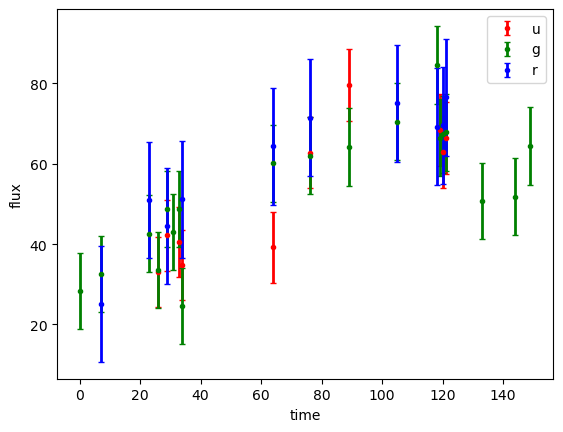

In [9]:
fmt_1 = ['.r','.g','.b','.k','.y','.m']
fmt_2 = ['dr','dg','db','dk','dy','dm']
color = ['r','g','b','k','y','m']
label = ['u','g','r','i','z','w']
data_sample = data_list[sample]
for i in range(3):
    mjd_ = data_sample[0][i]
    flux_ = data_sample[1][i]
    flux_err_ = data_sample[2][i]
    
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt_1[i], elinewidth=2, capsize=2,label=label[i])
    plt.legend()
    #plt.xlim(min(mjd),max(mjd))
    plt.xlabel("time")
    plt.ylabel("flux")

label_list[sample]

In [10]:
#打乱数据
np.random.shuffle(index_list)
shuffle_data_list = []
shuffle_label_list = []
shuffle_redshift_list = []

for i in index_list:
    shuffle_data_list.append(data_list[i])
    shuffle_label_list.append(label_list[i])
    shuffle_redshift_list.append(redshift_list[i])

len(shuffle_data_list), len(shuffle_redshift_list)

(19686, 19686)

redsfhit: 0.03726
lablel: 1.0


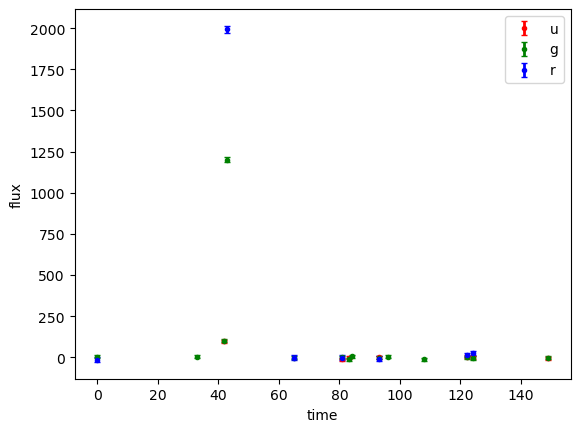

In [11]:
sample += 1
data_sample = shuffle_data_list[sample]
data_label = shuffle_label_list[sample]
data_redshift = shuffle_redshift_list[sample]
for i in range(3):
    mjd_ = data_sample[0][i]
    flux_ = data_sample[1][i]
    flux_err_ = data_sample[2][i]
    
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt_1[i], elinewidth=2, capsize=2,label=label[i])
    plt.legend()
    #plt.xlim(min(mjd),max(mjd))
    plt.xlabel("time")
    plt.ylabel("flux")

print(f"redsfhit: {data_redshift}")
print(f"lablel: {data_label}")

# 测试GP fit

In [12]:
# gp 拟合
gp_parameter_list = []
sample_size = len(shuffle_data_list)

import sys
import numpy as np
from tqdm import tqdm
sys.path.append("/home/yltang/data/lc_processor/python_code/tools")
from make_dense_light_curve_effective import make_dense_light_curve
make_dense = make_dense_light_curve(light_curve=None)

In [13]:
lc_list = []
concated_lc_list = []
fit_fail_list = []
with tqdm(total=sample_size*10, desc='Processing...', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
    for sample in range(len(shuffle_data_list)):
        mjd = []
        flux = []
        flux_err = []
        for i in range(3):
            mjd_ = shuffle_data_list[sample][0][i]
            flux_ = shuffle_data_list[sample][1][i]
            flux_err_ = shuffle_data_list[sample][2][i]
            mjd_ = np.array(mjd_)
            flux_ = np.array(flux_)
            flux_err_ = np.array(flux_err_)
            mjd.append(mjd_)
            flux.append(flux_)
            flux_err.append(flux_err_)
        
        lc = [mjd, flux, flux_err]
        concatnet_lc = make_dense.concatenate_lc(light_curve_info=lc)
        try:
            gp_ = make_dense.fit_gps(concat_lc=concatnet_lc)
            lc_list.append(lc)
            concated_lc_list.append(concatnet_lc)
            gp_parameter_list.append(gp_)
        except:
            fit_fail_list.append(sample)
            print(f"GP failed to fit this data: index{sample}")
            
        pbar.update(10)

Processing...: 100%|███████████████████████████████████████████████| 197k/197k [06:43<00:00, 488B/s]


In [14]:
def interpolation(lc):
    mjd_list = []
    flux_list = []
    flux_err_list = []
    weight = []
    for band in range(3):
        x_pred = np.linspace(min(time), max(time), int(max(time)-min(time))+1)
        x_pred = np.vstack([x_pred,np.ones(x_pred.shape)*central_wave_length[band]])
        pred, pred_var = gp_.predict(fluxes, x_pred.T, return_var=True)
        x_pred_ = x_pred[0,:]
        #print(x_pred_)

        mjd = x_pred_
        flux = pred
        flux_err = np.sqrt(pred_var)/5
        weight_pre_band = list(np.zeros(shape=(len(mjd),)))
        
        for i, generate_mjd in enumerate(mjd):
            for j, real_mjd in enumerate(lc[0][band]):
                if generate_mjd == real_mjd:
                    #print(generate_mjd, real_mjd)
                    flux[i] = lc[1][band][j]
                    flux_err[i] = lc[2][band][j]
                    weight_pre_band[i] = 1.
                    #print(weight_pre_band[i])
                    break
                    
        #print(weight_pre_band)       
        mjd_list.append(mjd)
        flux_list.append(flux)
        flux_err_list.append(flux_err)
        weight.append(weight_pre_band)

    interpolated_data = [mjd_list, flux_list, flux_err_list]
    return interpolated_data, weight

In [15]:
central_wave_length = [3570.0,4767.0,6215.0,7545.0,8708.0,10040.0]
central_wave_length = np.array(central_wave_length)

In [16]:
interpolated_data_list = []
weight_list = []
with tqdm(total=sample_size*10, desc='Processing...', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
    for sample in range(len(lc_list)):
        lc = lc_list[sample]
        concatnet_lc = concated_lc_list[sample]
        gp_ = gp_parameter_list[sample]
        time = concatnet_lc[0]
        fluxes = concatnet_lc[1]
        flux_errs = concatnet_lc[2]
        filters = concatnet_lc[3]
        try:
            interpolated_data, weight = interpolation(lc=lc)
            interpolated_data_list.append(interpolated_data)
            weight_list.append(weight)
        except:
            fit_fail_list.append(sample)
            print(f"GP failed to fit this data: index{sample}")
        pbar.update(10)

Processing...:   1%|▌                                           | 2.77k/197k [00:01<01:32, 2.09kB/s]/tmp/ipykernel_786549/4190974269.py:15: RuntimeWarning: invalid value encountered in sqrt
  flux_err = np.sqrt(pred_var)/5
Processing...: 100%|█████████████████████████████████████████████| 197k/197k [01:34<00:00, 2.09kB/s]


In [17]:
len(interpolated_data_list)

19686

# 找到trigger的点

In [18]:
def trigger(data):
    """
    """
    trigger_list = []
    for index in range(len(data)):
        mjd_ = data[index][0][1]
        flux_ = data[index][1][1]
        flux_err_ = data[index][2][1]
        #print(len(flux_), len(flux_err_))
        max_index = np.argmax(flux_)
        for j, _ in enumerate(flux_):
            if flux_[j] > 5*flux_err_[j]:
                trigger = mjd_[j]
                break
        #print(trigger, max_index)
        trigger_list.append(trigger)
       

    return (trigger_list)

In [19]:
trigger_list = trigger(data=shuffle_data_list)

In [20]:
trigger_list[:10]

[34.0, 43.0, 42.0, 34.0, 36.0, 41.0, 14.0, 52.0, 35.0, 36.0]

In [21]:
for j, i in enumerate(trigger_list):
    if i>=60:
        fit_fail_list.append(j)

In [22]:
len(fit_fail_list)

92

In [23]:
index_list = list(range(len(data_list)))
selected_index = []
for index in index_list:
    if index not in fit_fail_list:
        selected_index.append(index)

In [24]:
len(selected_index)

19594

In [25]:
selected_data_list = []
selected_label_list = []
selected_redshift_list = []
selected_trigger_list = []
selected_interpolate_data_list = []
for i in selected_index:
    selected_interpolate_data_list.append(interpolated_data_list[i])
    selected_trigger_list.append(trigger_list[i])
    selected_data_list.append(shuffle_data_list[i])
    selected_label_list.append(shuffle_label_list[i])
    selected_redshift_list.append(shuffle_redshift_list[i])
len(selected_data_list), len(selected_redshift_list), len(selected_trigger_list), len(selected_interpolate_data_list), len(selected_label_list)

(19594, 19594, 19594, 19594, 19594)

In [26]:
selected_weight_list = []
for i in selected_index:
    selected_weight_list.append(weight_list[i])
len(selected_weight_list)

19594

In [27]:
selected_trigger_list[:10]

[34.0, 43.0, 42.0, 34.0, 36.0, 41.0, 14.0, 52.0, 35.0, 36.0]

In [28]:
sample = 0

redshift: 0.02684
label: 1.0


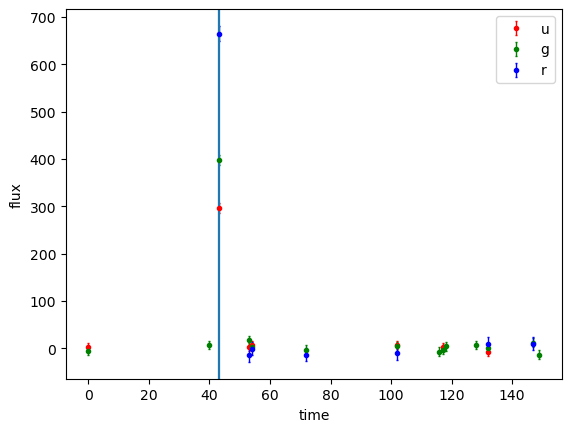

In [29]:
sample += 1
for i in range(3):
    mjd_ = selected_interpolate_data_list[sample][0][i]
    trigger_mjd = selected_trigger_list[sample]
    flux_ = selected_interpolate_data_list[sample][1][i]
    flux_err_ = selected_interpolate_data_list[sample][2][i]
    
    plt.errorbar(x=selected_data_list[sample][0][i], y=selected_data_list[sample][1][i], yerr=selected_data_list[sample][2][i], fmt=fmt_1[i], elinewidth=1, capsize=1, label=label[i])
    plt.legend()
    plt.axvline(x=trigger_mjd)
    plt.xlabel("time")
    plt.ylabel("flux")
print(f"redshift: {shuffle_redshift_list[sample]}")
print(f"label: {shuffle_label_list[sample]}")

150 150
150 150
150 150


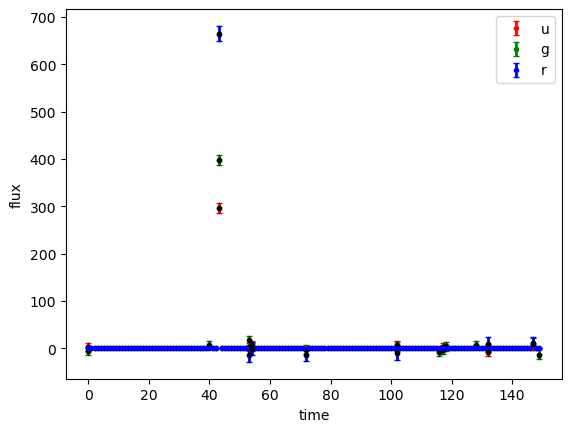

In [30]:
for i in range(3):
    mjd_ = selected_interpolate_data_list[sample][0][i]
    flux_ = selected_interpolate_data_list[sample][1][i]
    flux_err_ = selected_interpolate_data_list[sample][2][i]
    
    flux_ = flux_ * selected_weight_list[sample][i]
    flux_err_ = flux_err_ * selected_weight_list[sample][i]
    print(len(mjd_), len(flux_))
    
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt_1[i], elinewidth=2, capsize=2,label=label[i])
    plt.errorbar(x=selected_data_list[sample][0][i], y=selected_data_list[sample][1][i], yerr=selected_data_list[sample][2][i], fmt=".k", elinewidth=0.1, capsize=0.3)
    #plt.fill_between(x_pred_, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color=color[band], alpha=0.5)
    plt.legend()
    #plt.xlim(min(mjd),max(mjd))
    plt.xlabel("time")
    plt.ylabel("flux")

# 裁剪数据

In [31]:
len(selected_data_list), len(selected_redshift_list),  len(selected_trigger_list), len(selected_interpolate_data_list)

(19594, 19594, 19594, 19594)

In [32]:
len(selected_data_list[0][0][0])

10

In [33]:
num = len(selected_data_list)

In [34]:
len(weight_list[0][0])

150

In [35]:
for i in selected_trigger_list:
    if i>=60:
        print("!!!")
        break

In [36]:
def generat_lc(sample_size, num_band=3, num_time_steps=int(90)):
    train_data = np.zeros([sample_size, num_time_steps, num_band * 2])
    with tqdm(total=num*10, desc='Processing...', leave=True, ncols=100, unit='B', unit_scale=True) as pbar:
        for index in range(num):
            single_lc = selected_interpolate_data_list[index]
            for k in range(num_band):
                for l in range(num_time_steps):
                    if selected_trigger_list[index]>3:
                        train_data[index, l, k] = single_lc[1][k][l+int(selected_trigger_list[index])-3]
                        train_data[index, l, k + num_band] = single_lc[2][k][l+int(selected_trigger_list[index])-3]
                    else:
                        train_data[index, l, k] = single_lc[1][k][l+int(selected_trigger_list[index])]
                        train_data[index, l, k + num_band] = single_lc[2][k][l+int(selected_trigger_list[index])]
            pbar.update(10)
    return train_data

In [37]:
selected_data_array = generat_lc(sample_size=len(selected_data_list))

Processing...: 100%|█████████████████████████████████████████████| 196k/196k [00:03<00:00, 52.4kB/s]


(90,) (90,)
(90,) (90,)
(90,) (90,)
redshift: 0.23234
label: 3.0


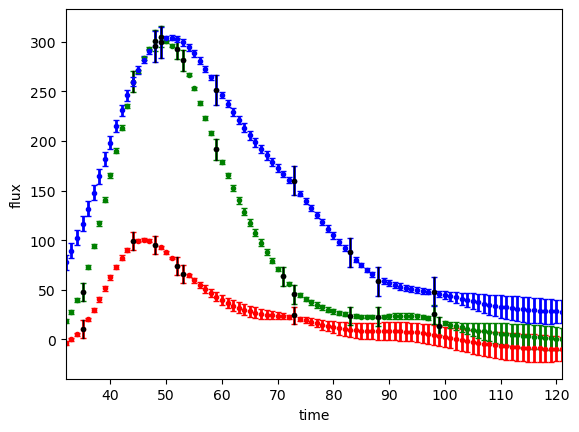

In [56]:
sample += 1
for i in range(3):
    if selected_trigger_list[sample]<3:
        mjd_ = np.linspace(0,89, 90)+selected_trigger_list[sample]
    else:
        mjd_ = np.linspace(0,89, 90)+selected_trigger_list[sample]-3
    flux_ = selected_data_array[sample, :, i]
    flux_err_ = selected_data_array[sample, :, i+3]
    print(flux_.shape, flux_err_.shape)
    plt.errorbar(x=mjd_, y=flux_, yerr=flux_err_, fmt=fmt_1[i], elinewidth=2, capsize=2,label=label[i])
    plt.errorbar(x=selected_data_list[sample][0][i], y=selected_data_list[sample][1][i], yerr=selected_data_list[sample][2][i], fmt=".k", elinewidth=1, capsize=1)
    #plt.fill_between(mjd_, flux_ - flux_err_, flux_ + flux_err_, color=color[i], alpha=0.5)
    
    plt.xlim(min(mjd_),max(mjd_))
    plt.xlabel("time")
    plt.ylabel("flux")

print(f"redshift: {selected_redshift_list[sample]}")
print(f"label: {selected_label_list[sample]}")

In [39]:
def generate_label(label):
    gen_label = np.zeros([len(label), 9])
    for i, label_ in enumerate(label):
        gen_label[i, int(label_)] = 1
    return gen_label

In [40]:
selected_label_array = generate_label(label=selected_label_list)

In [41]:
selected_label_array.shape

(19594, 9)

In [42]:
sample += 1
int(selected_label_list[sample]), np.argmax(selected_label_array[sample])

(8, 8)

In [43]:
selected_weight_array = np.array(selected_weight_list)
selected_weight_array.shape

(19594, 3, 150)

In [44]:
# 将处理好的数据保存为张量文件
# selected_data_list: 原始数据, 列表格式，可以直接保存为json文件
# selected_redshift_list: 红移数据, 列表格式

# selected_interpolated_data_list --> ***data.npz: 包含原始数据+插值后的数据，需要转换成np.array格式方便后面神经网络使用
# sekected_weight_list --> ***weigh.npz: 包含区分原始数据和插值数据的权重，需要转换成np.array格式方便后面使用
# selected_label_list --> ***label.npz: 标签数据， 列表格式，需要转换成np.array格式方便后面使用

In [45]:
np.savez(f'/home/yltang/data/work_1/data_3/{train_test}_data.npz', data = selected_data_array)
np.savez(f'/home/yltang/data/work_1/data_3/{train_test}_label.npz', data = selected_label_array)
np.savez(f'/home/yltang/data/work_1/data_3/{train_test}_weight.npz', data = selected_weight_array)